In [2]:
import os 
os.chdir("../src")
print(os.getcwd())

import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.utils import io

from envs.goal_demo_wrapper import GoalDemoWrapper
from utils.load_confs import load_parameters, load_paths

%matplotlib inline
%load_ext autoreload
%autoreload 2

/u/clw4542/research/rl_ifo_mujoco/src


In [3]:
ENV_IDS = [
           "Reacher-v2",
           "Swimmer-v2", 
           "Ant-v2", 
           "Hopper-v2", 
           "Walker2d-v2", 
           "HalfCheetah-v2"
          ]

paths = load_paths()
params = load_parameters()
RESULTS_DIR = paths['rl_demo']['results_dir']
env_id = ENV_IDS[1]
expt_name = "her_demo"
algo = "sac"


### Plotting Utils

In [4]:
# random perf
random_perf = {'Reacher-v2': -43.1199222, 
               'HalfCheetah-v2': -282.7423069, 
               'Ant-v2': -54.35667815, 
               'Walker2d-v2': 0.55296615, 
               'Swimmer-v2': 1.4335161, 
               'Hopper-v2': 18.14677599}

# expert perf
expert_perf = {}
expert_average_perf = {}
for env in ["Reacher-v2", "Swimmer-v2", "Ant-v2", "Walker2d-v2", "Hopper-v2", "Swimmer-v2", "HalfCheetah-v2"]: 
    data = np.load(f"../data/expert_joint_angle_traj/original_init/joint_angles_sac.{env}.seed=None.npz")
    rew = data['rew']
    expert_perf[env] = rew

    data = np.load(f"../data/expert_full_traj/original_init/sac.{env}.seed=None.npz")
    expert_average_perf[env] = np.mean(data['ep_rets'])
    
display(random_perf)
display(expert_perf)
display(expert_average_perf)
%store random_perf
%store expert_perf
%store expert_average_perf

{'Reacher-v2': -43.1199222,
 'HalfCheetah-v2': -282.7423069,
 'Ant-v2': -54.35667815,
 'Walker2d-v2': 0.55296615,
 'Swimmer-v2': 1.4335161,
 'Hopper-v2': 18.14677599}

{'Reacher-v2': array(-1.14986092),
 'Swimmer-v2': array(146.58015019),
 'Ant-v2': array(6284.88158958),
 'Walker2d-v2': array(5940.55661373),
 'Hopper-v2': array(3851.98779776),
 'HalfCheetah-v2': array(12282.15422657)}

{'Reacher-v2': -4.44610456767987,
 'Swimmer-v2': 105.0921405698137,
 'Ant-v2': 6068.579720375406,
 'Walker2d-v2': 5724.123982401997,
 'Hopper-v2': 3614.2925763870617,
 'HalfCheetah-v2': 11900.94703180497}

Stored 'random_perf' (dict)
Stored 'expert_perf' (dict)
Stored 'expert_average_perf' (dict)


In [5]:
from collections import deque 
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

# version for reading stable baselines logs 
def read_learning_data(log_path:str):
    mean_ep_rets = []
    std_ep_rets = []
    ts_so_far = []
    ep_idx = 0 
    ret_buffer = deque(maxlen=100)
    for summary in tf.train.summary_iterator(log_path):
        for v in summary.summary.value:
            if v.tag == 'episode_reward':
                ep_idx += 1
                ret_buffer.append(v.simple_value)
                if ep_idx % 50 == 0:
                    mean_ep_rets.append(np.mean(ret_buffer))
                    std_ep_rets.append(np.std(ret_buffer))
                    timestep = summary.step
                    ts_so_far.append(timestep)        
    return ts_so_far, mean_ep_rets, std_ep_rets

def read_eval_data(log_path:str, max_ts=3e+6):
    eval_data = np.load(os.path.join(log_path, "evaluations.npz"))
    #     eval_data = np.load("/scratch/cluster/clw4542/ridm_results/baseline_rl/log/sac_Reacher-v2_1/evaluations.npz")
    ts = eval_data["timesteps"]
    results = eval_data["results"]
    ep_lens = eval_data["ep_lengths"]
    
    # take avg of results 
    mean_res, std_res = np.mean(results, axis=1), np.std(results, axis=1)
    if len(mean_res.shape) > 1 : 
        mean_res, std_res = mean_res[:,0], std_res[:,0]
    mean_res = uniform_filter1d(mean_res, size=15)
    # take avg of ep_lens, no smoothing 
    mean_lens, std_lens = np.mean(ep_lens, axis=1), np.std(ep_lens, axis=1)
    if len(mean_lens.shape) > 1 : 
        mean_lens, std_lens = mean_lens[:,0], std_lens[:,0]    
        
    truncated_ts = [i for i in ts if i < max_ts]
    max_idx = len(truncated_ts)
    
    if "goal_dists" in eval_data.keys():
        goal_dist = eval_data["goal_dists"]
        mean_goal_dist = np.mean(goal_dist, axis=1)
        std_goal_dist = np.std(goal_dist, axis=1)
    else: 
        mean_goal_dist, std_goal_dist = [], []

    return ts[:max_idx], mean_res[:max_idx], std_res[:max_idx], \
           mean_lens[:max_idx], std_lens[:max_idx], \
           mean_goal_dist[:max_idx], std_goal_dist[:max_idx]
    
        
def plot_algo_with_demo(logs_dict, algo, env, eval_mode=False):
    '''the result should be a tuple of 2 lists, representing the x and y coords to plot'''
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    for label, result in logs_dict.items():
        time_idx, mean, std, mean_lens, std_lens, mean_goal_dist, std_goal_dist = result
        p = ax.plot(time_idx, mean, label=label)
        color = p[0].get_color()
        std = np.array(std)
        ax.fill_between(time_idx, mean-std/2, mean+std/2,
                        alpha=0.5, edgecolor=color, facecolor=color 
                       )
    ax.axhline(y=expert_perf[env], color='black', linestyle='--', label='expert demo ret')
    ax.axhline(y=expert_average_perf[env], color='gray', linestyle='--', label='expert avg ret')
    ax.axhline(y=random_perf[env], color='lightgray', linestyle='--', label='random ret')

    ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

    mode = "eval" if eval_mode else "learn"
    ax.set_title(f"{algo.upper()} on {env} (mode={mode})", fontsize=20)
    if eval_mode: 
        ax.set_ylabel("Mean Ep Rets \n(avg over 100 eps)", fontsize=16)
    else: 
        ax.set_ylabel("Mean Ep Rets", fontsize=16)
    ax.set_xlabel("Timesteps", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())

    plt.show()
    plt.close()

def plot_goal_dist(logs_dict, algo, env):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    for label, result in logs_dict.items():
        time_idx, mean, std, mean_lens, std_lens, mean_goal_dist, std_goal_dist = result
        p = ax.plot(time_idx, mean_goal_dist, label=label)
        color = p[0].get_color()
        std_goal_dist = np.array(std_goal_dist)
        ax.fill_between(time_idx, mean_goal_dist-std_goal_dist/2, mean_goal_dist+std_goal_dist/2,
                        alpha=0.5, edgecolor=color, facecolor=color 
                       )

    ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title(f"Goal Distance of {algo.upper()} on {env}", fontsize=20)
    ax.set_xlabel("Timesteps", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.show()
    plt.close()

def plot_ep_lens(logs_dict, algo, env):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    for label, result in logs_dict.items():
        time_idx, mean, std, mean_lens, std_lens, mean_goal_dist, std_goal_dist = result
        p = ax.plot(time_idx, mean_lens, label=label)
        color = p[0].get_color()
        std_lens = np.array(std_lens)
        ax.fill_between(time_idx, mean_lens-std_lens/2, mean_lens+std_lens/2,
                        alpha=0.5, edgecolor=color, facecolor=color 
                       )

    ax.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_title(f"Ep Len of {algo.upper()} on {env}", fontsize=20)
    ax.set_xlabel("Timesteps", fontsize=16)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.show()
    plt.close()


def newest(path):
    '''Returns full path of newest file in given path'''
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages

## Plot Results

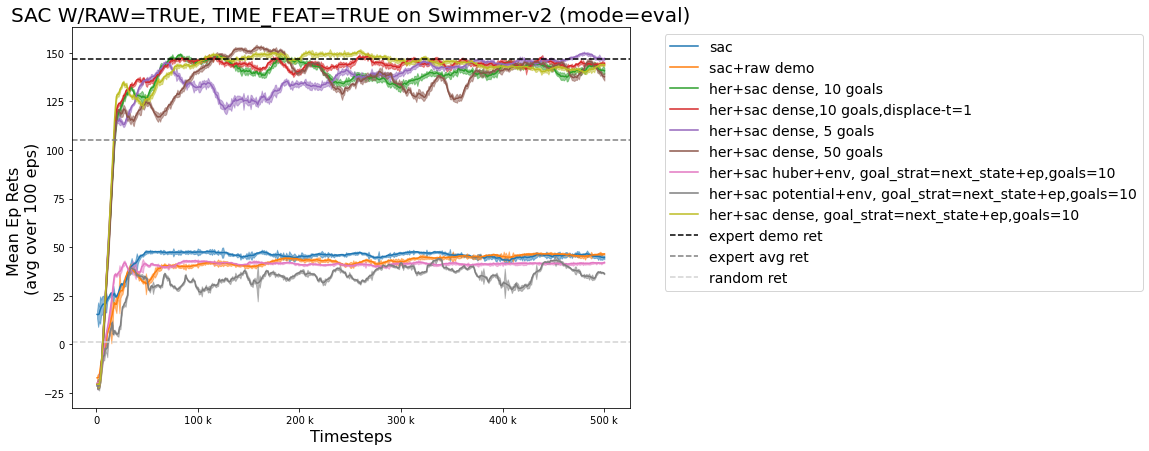

In [5]:
env_id = "Swimmer-v2"
run_id = 1
for raw in [
            True, 
#             False
            ]:
    if raw: 
        obs_type = "raw"
    else:
        obs_type = "full"
    for time_feat in [True, 
#                       False
                     ]:
        if time_feat: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}_{run_id}/"),        
                          f"{algo}+{obs_type} demo": read_eval_data(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t=0_demo=sac/log/{algo}_{env_id}_{run_id}/"),                                     
                             }
        else: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/baseline_rl/log/{algo}_{env_id}_1/"),
                             }

        eval_data_dict = {**eval_data_dict,
#                   f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat=episode_n-goal=0_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                 
#                   f"her+{algo} huber+env, 10 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env, 10 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} dense, 10 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                   f"her+{algo} huber+env,10 goals,displace-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env,10 goals,displace-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} dense,10 goals,displace-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                           
#                   f"her+{algo} huber+env, 5 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env, 5 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} dense, 5 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                   f"her+{algo} huber+env, 50 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=50_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env, 50 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=50_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} dense, 50 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=50_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                         }

        if raw and time_feat: 
            eval_data_dict = {**eval_data_dict, 
#                           f"her+{algo} huber+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                          f"her+{algo} huber+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
                          f"her+{algo} potential+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                          f"her+{algo} dense, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                              
                             }
        plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()} w/raw={raw}, time_feat={time_feat}", env=env_id, eval_mode=True)


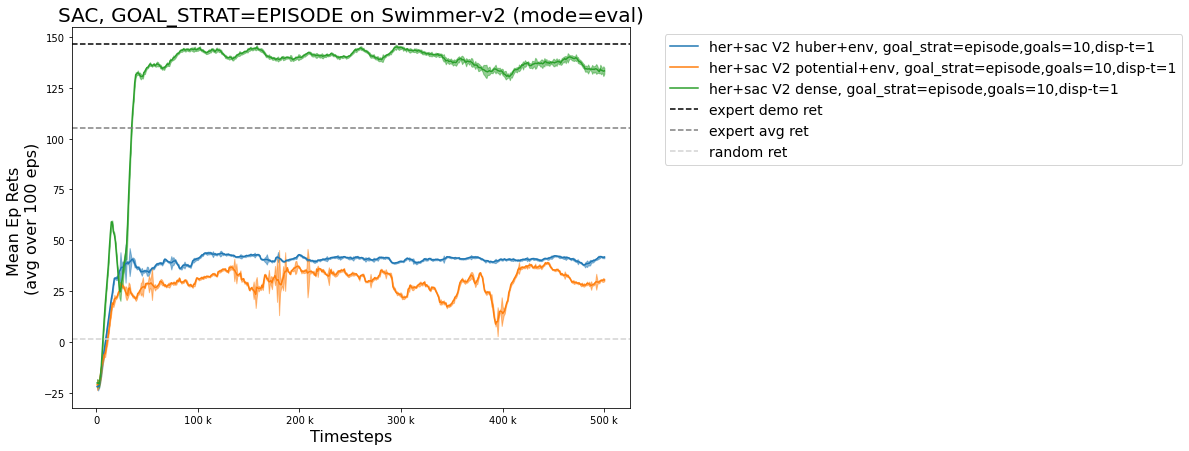

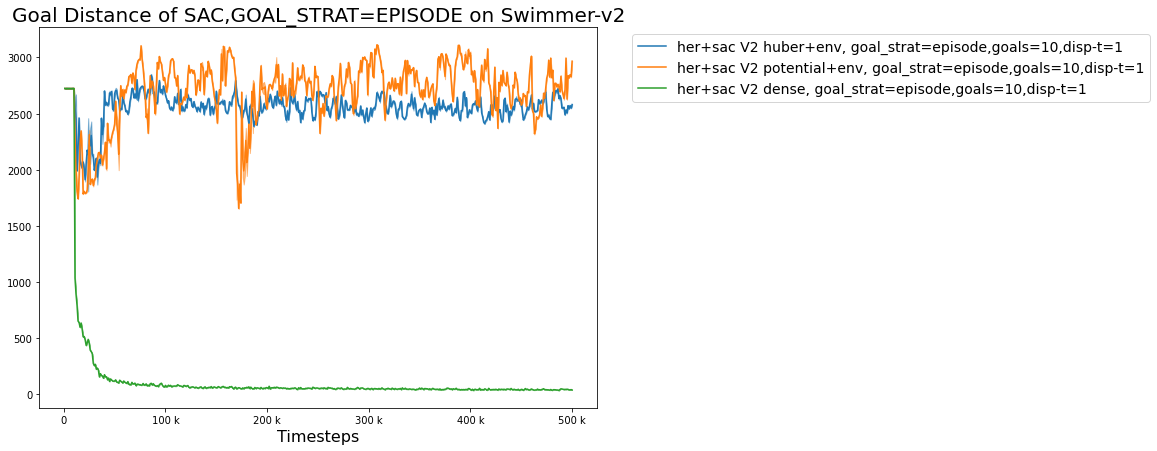

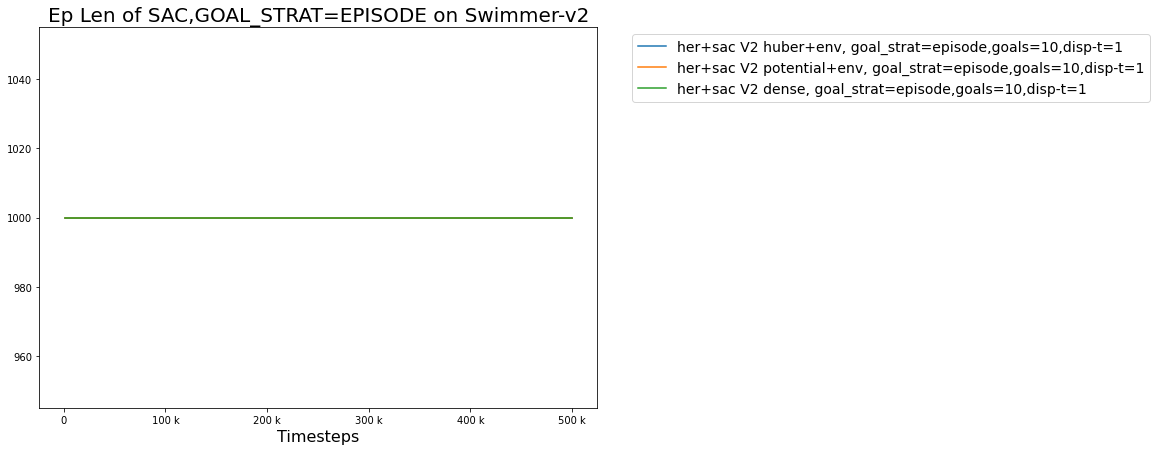

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/ridm_results//her_demo-v2_rew=huber+env_raw=True_goal-strat=future_n-goal=10_time-feat=True_displace-t=1/log/sac_Swimmer-v2_1/evaluations.npz'

In [45]:
env_id = "Swimmer-v2"
run_id = 1
for raw in [True]:
    obs_type = "raw"
    for time_feat in [True]:
        for goal_strat in [
#                            "next_state_and_ep",  
                           "episode",
                           "future",
#                            "next_state", 
#                            "episode_nearest"
                          ]:
            if goal_strat == "episode_nearest":
                eval_data_dict = {
                      f"her+{algo} V2-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} V2-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} V2-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),                    
                }
            else: 
                eval_data_dict = {
#                       f"her+{algo} V2 huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} V2 potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} V2 dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

                      f"her+{algo} V2-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} V2-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} V2-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }

            if goal_strat == "next_state_and_ep": 
                eval_data_dict = {**eval_data_dict,
                      f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat={goal_strat}_n-goal=0_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()}, GOAL_STRAT={goal_strat}", env=env_id, eval_mode=True)
            plot_goal_dist(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)
            plot_ep_lens(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)

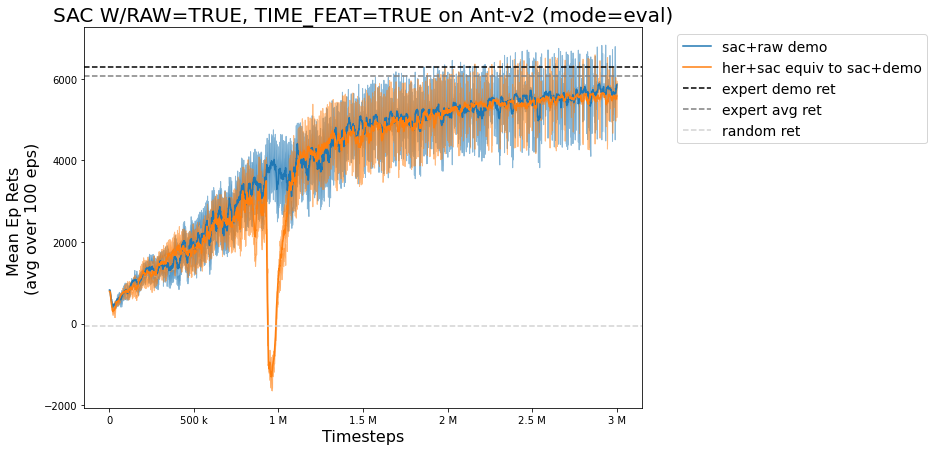

In [26]:
env_id = "Ant-v2"
run_id = 1
for raw in [
            True, 
#             False
            ]:
    if raw: 
        obs_type = "raw"
    else:
        obs_type = "full"
        
    for time_feat in [True, 
                      #False
                     ]:
        if time_feat: 
            eval_data_dict = {
#                           f"{algo}": read_eval_data(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}_{run_id}/"),        
                          f"{algo}+{obs_type} demo": read_eval_data(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t=0_demo=sac/log/{algo}_{env_id}_{run_id}/"),                                     
                             }
        else: 
            eval_data_dict = {
#                           f"{algo}": read_eval_data(f"{RESULTS_DIR}/baseline_rl/log/{algo}_{env_id}_1/"),
                             }

        eval_data_dict = {**eval_data_dict,
                  f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat=episode_n-goal=0_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                   f"her+{algo} huber+env": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                   f"her+{algo} dense": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                         }

        if raw and time_feat: 
            eval_data_dict = {**eval_data_dict, 
#                           f"her+{algo} huber+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                             }

        plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()} w/raw={raw}, time_feat={time_feat}", env=env_id, eval_mode=True)


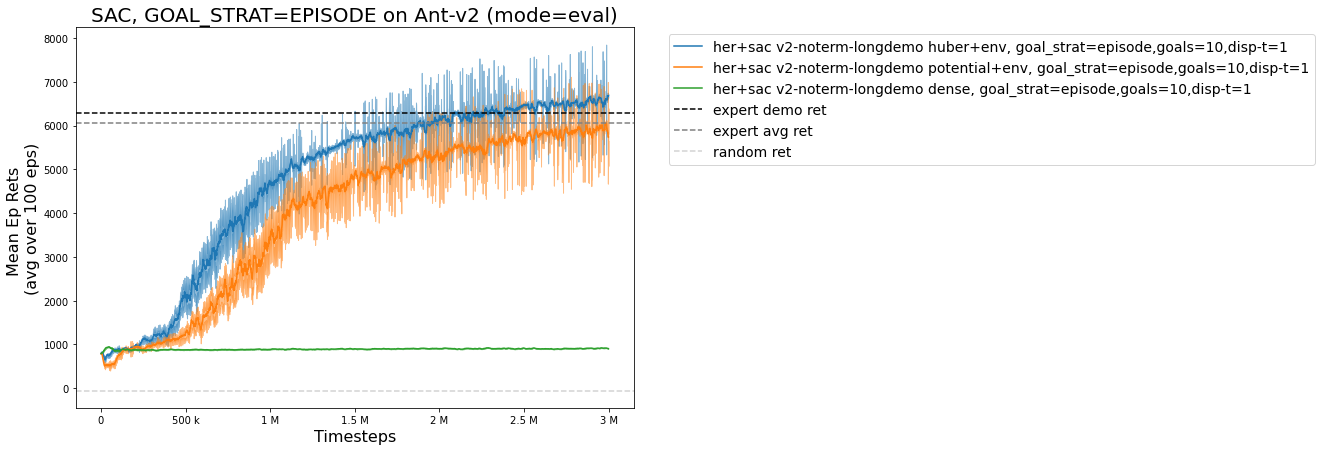

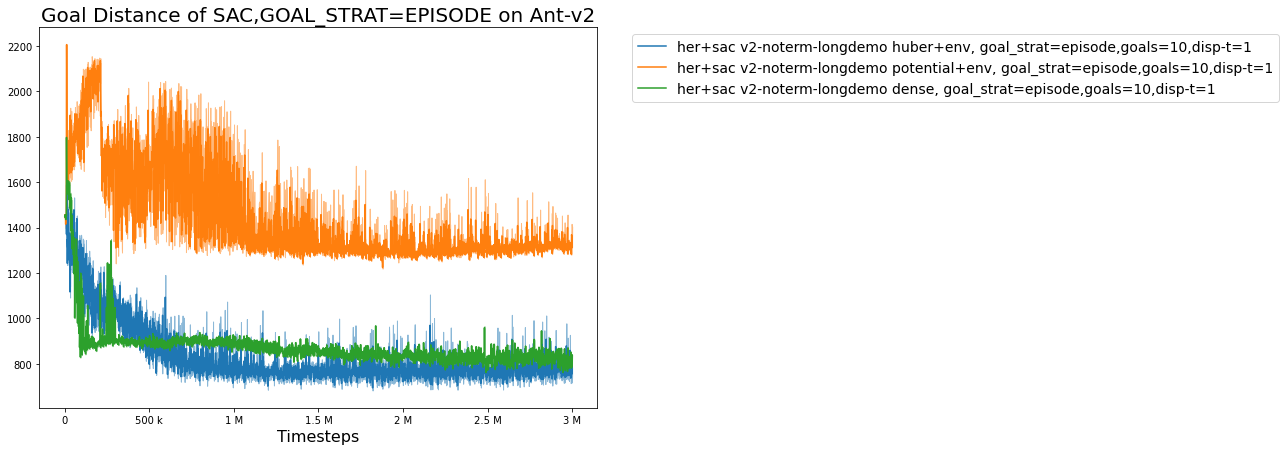

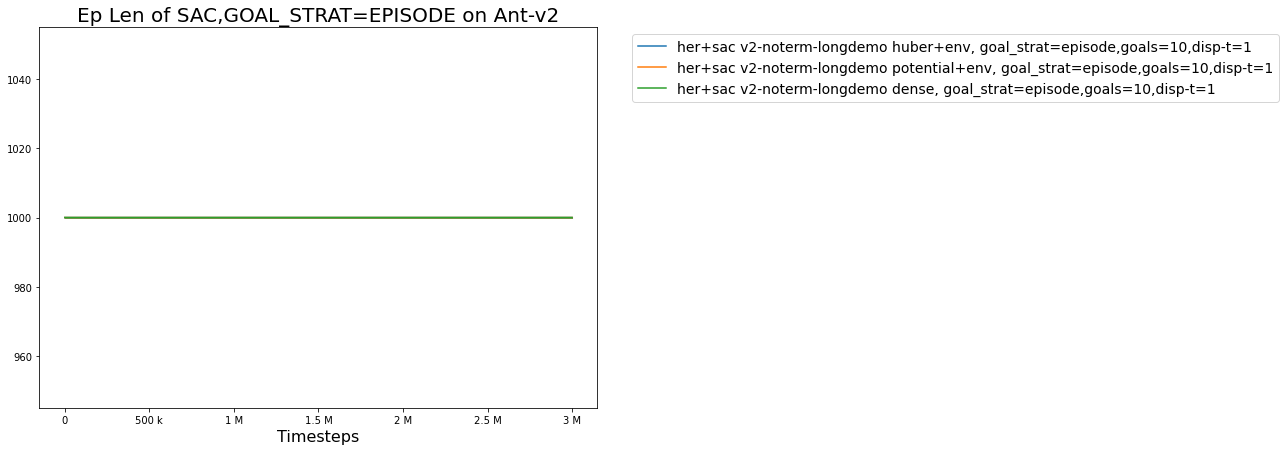

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/ridm_results//her_demo-noterm-longdemo_rew=potential_dense_raw=True_goal-strat=future_n-goal=10_time-feat=True_displace-t=1/log/sac_Ant-v2_1/evaluations.npz'

In [47]:
env_id = "Ant-v2"
run_id = 1
for raw in [True, False]:
    obs_type = "raw"
    for time_feat in [True]:
        for goal_strat in [
#                            "next_state_and_ep",  
                           "episode",
#                            "next_state", 
                           "future",             
                           "episode_nearest"
                          ]:
            if goal_strat == "episode_nearest" or goal_strat == "future":
                eval_data_dict = {
                      f"her+{algo} V2-noterm-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} V2-noterm-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} V2-noterm-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),                    
                }
            else: 
                eval_data_dict = {
#                       f"her+{algo} v2-noterm huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} v2-noterm potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} v2-noterm dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

                      f"her+{algo} v2-noterm-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} v2-noterm-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} v2-noterm-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                
#                       f"her+{algo} V2 huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} V2 potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} V2 dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            if goal_strat == "next_state_and_ep": 
                eval_data_dict = {**eval_data_dict,
                              f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat={goal_strat}_n-goal=0_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                               f"her+{algo} huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                               f"her+{algo} potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                               f"her+{algo} dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()}, GOAL_STRAT={goal_strat}", env=env_id, eval_mode=True)
            plot_goal_dist(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)
            plot_ep_lens(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)

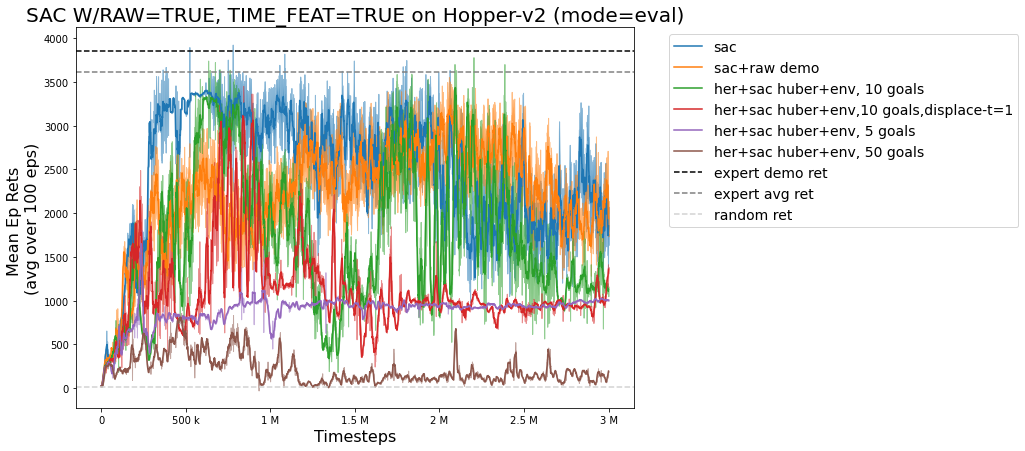

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/ridm_results//her_demo_rew=huber+env_raw=True_goal-strat=episode_n-goal=10_time-feat=False_displace-t=1/log/sac_Hopper-v2_1/evaluations.npz'

In [6]:
env_id = "Hopper-v2"
run_id = 1
for raw in [
            True, 
#             False
            ]:
    if raw: 
        obs_type = "raw"
    else:
        obs_type = "full"
        
    for time_feat in [True, False]:
        if time_feat: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}_{run_id}/"),        
                          f"{algo}+{obs_type} demo": read_eval_data(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t=0_demo=sac/log/{algo}_{env_id}_{run_id}/"),                                     
                             }
        else: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/baseline_rl/log/{algo}_{env_id}_2/"),
                             }

        eval_data_dict = {**eval_data_dict,
#                   f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat=episode_n-goal=0_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} huber+env, 10 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env, 10 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                   f"her+{algo} dense, 10 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                  f"her+{algo} huber+env,10 goals,displace-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env,10 goals,displace-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                   f"her+{algo} dense,10 goals,displace-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

                  f"her+{algo} huber+env, 5 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env, 5 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                   f"her+{algo} dense, 5 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                  f"her+{algo} huber+env, 50 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=50_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                   f"her+{algo} potential+env, 50 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=50_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                   f"her+{algo} dense, 50 goals": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=50_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                         }

        if raw and time_feat: 
            eval_data_dict = {**eval_data_dict, 
#                           f"her+{algo} huber+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=5,noise=1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=5,noise=1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=5,noise=1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                              
                             }

        plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()} w/raw={raw}, time_feat={time_feat}", env=env_id, eval_mode=True)


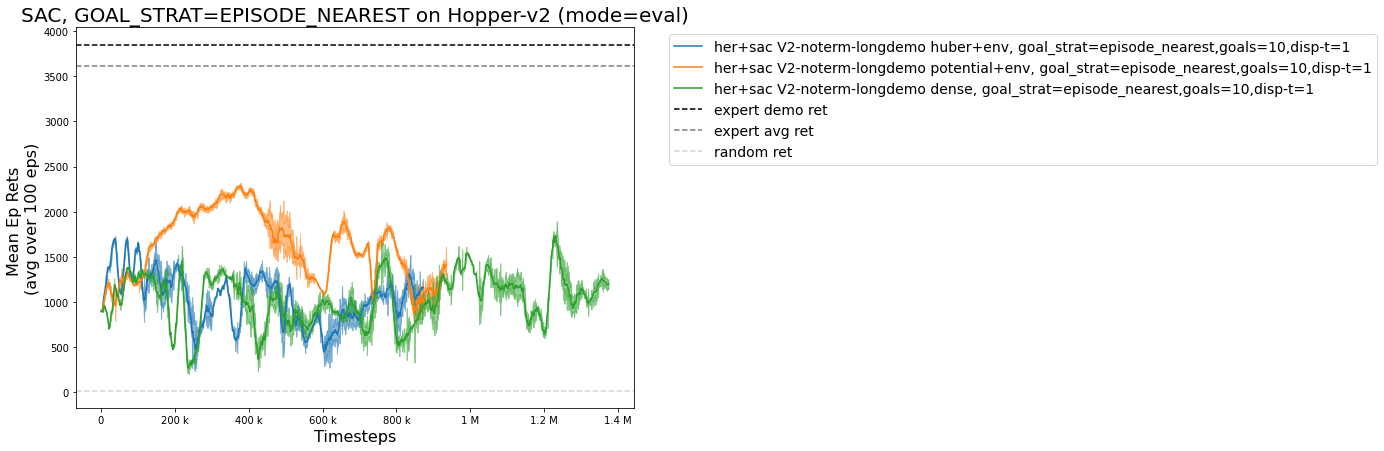

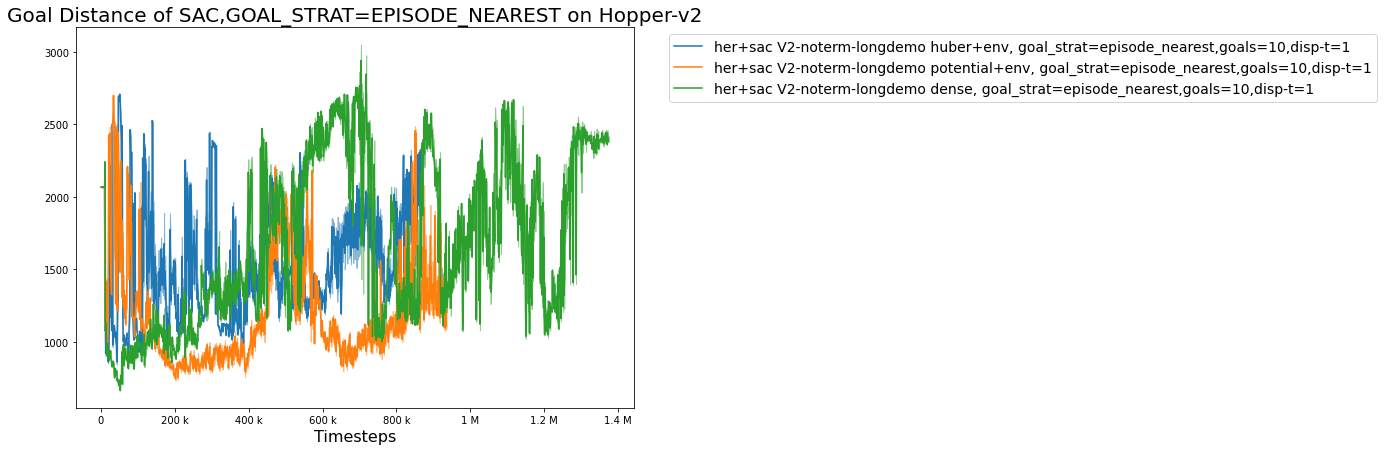

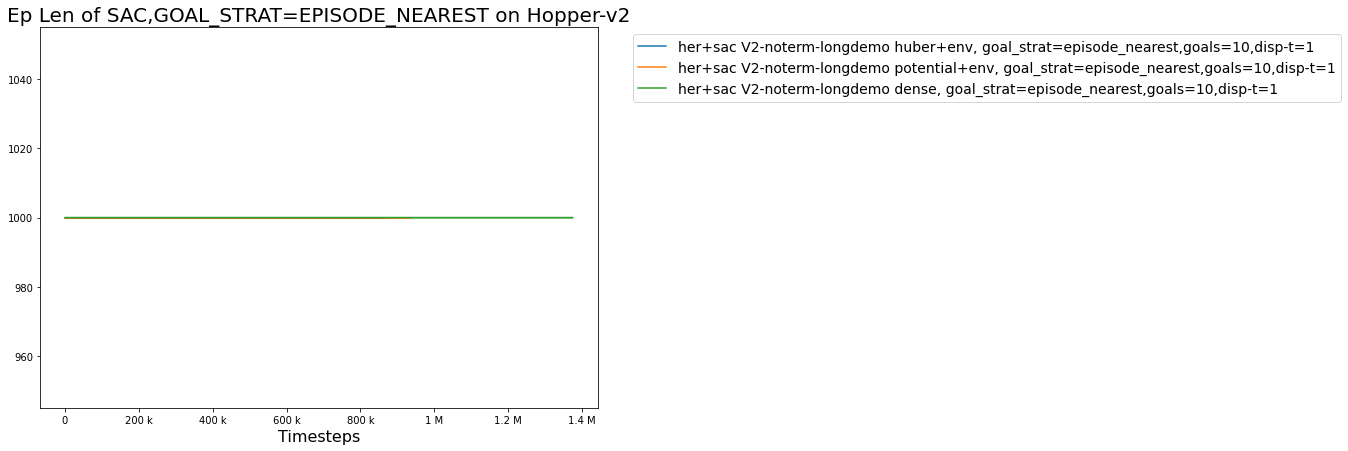

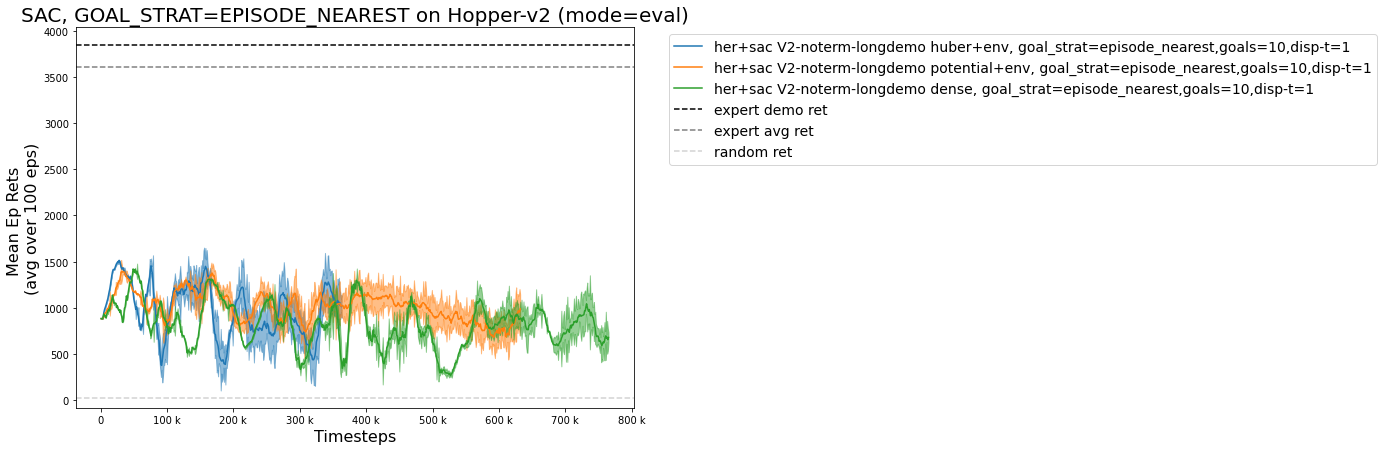

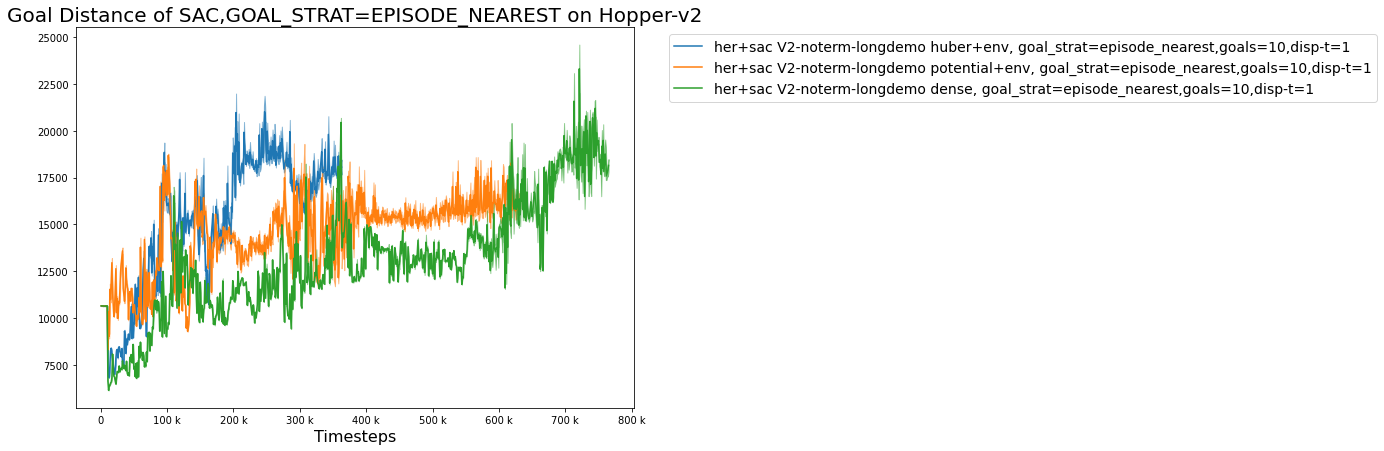

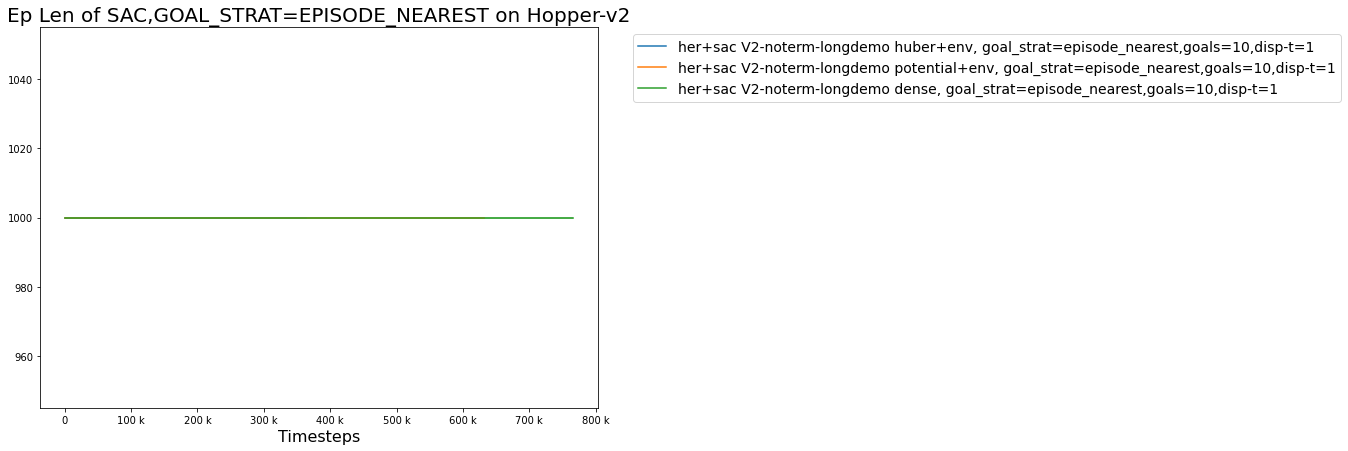

In [33]:
env_id = "Hopper-v2"
run_id = 1
for raw in [True, False]:
    obs_type = "raw"
    for time_feat in [True]:
        for goal_strat in [
#                            "next_state_and_ep",  
#                            "episode",
#                            "next_state", #"future"
                           "episode_nearest"
                          ]:
            if goal_strat == "episode_nearest":
                eval_data_dict = {
                      f"her+{algo} V2-noterm-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} V2-noterm-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} V2-noterm-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),                    
                }
            else: 
                eval_data_dict = {
                      f"her+{algo} noterm huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} noterm potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} noterm dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

                      f"her+{algo} v2-noterm-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} v2-noterm-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} v2-noterm-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

#                       f"her+{algo} V2 huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} V2 potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} V2 dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            if goal_strat == "next_state_and_ep": 
                eval_data_dict = {**eval_data_dict,
                      f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat={goal_strat}_n-goal=0_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()}, GOAL_STRAT={goal_strat}", env=env_id, eval_mode=True)
            plot_goal_dist(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)
            plot_ep_lens(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)

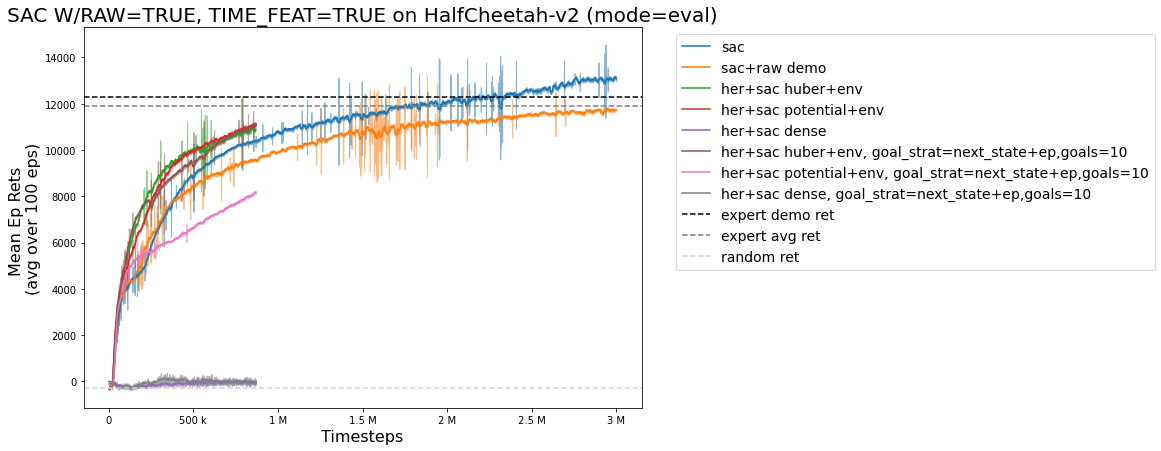

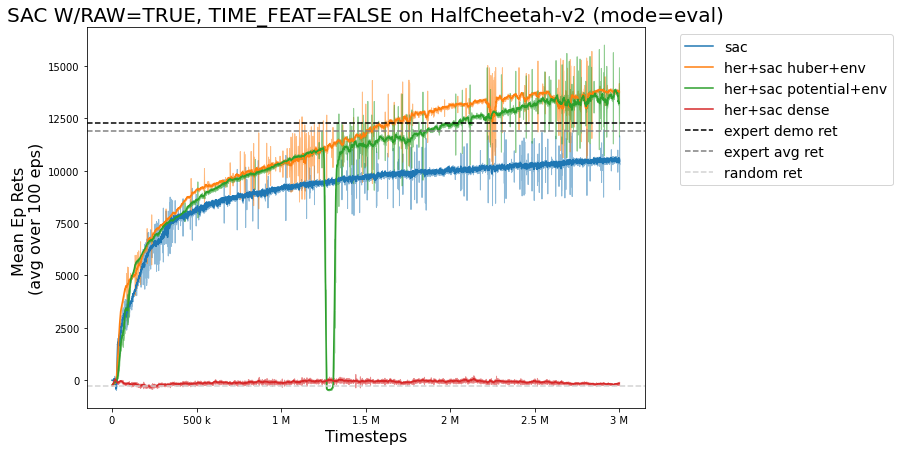

In [18]:
env_id = "HalfCheetah-v2"
run_id = 1
for raw in [
            True, 
#             False
            ]:
    if raw: 
        obs_type = "raw"
    else:
        obs_type = "full"
    for time_feat in [True, False]:
        if time_feat: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}_{run_id}/"),        
                          f"{algo}+{obs_type} demo": read_eval_data(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t=0_demo=sac/log/{algo}_{env_id}_{run_id}/"),                                     
                             }
        else: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/baseline_rl/log/{algo}_{env_id}_1/"),
                             }

        eval_data_dict = {**eval_data_dict,
#                   f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat=episode_n-goal=0_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} huber+env": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
                  f"her+{algo} potential+env": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} dense": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                         }

        if raw and time_feat: 
            eval_data_dict = {**eval_data_dict, 
#                           f"her+{algo} huber+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=10,noise=1e-3": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                          f"her+{algo} huber+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
                          f"her+{algo} potential+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                          f"her+{algo} dense, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                             }

        plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()} w/raw={raw}, time_feat={time_feat}", env=env_id, eval_mode=True)


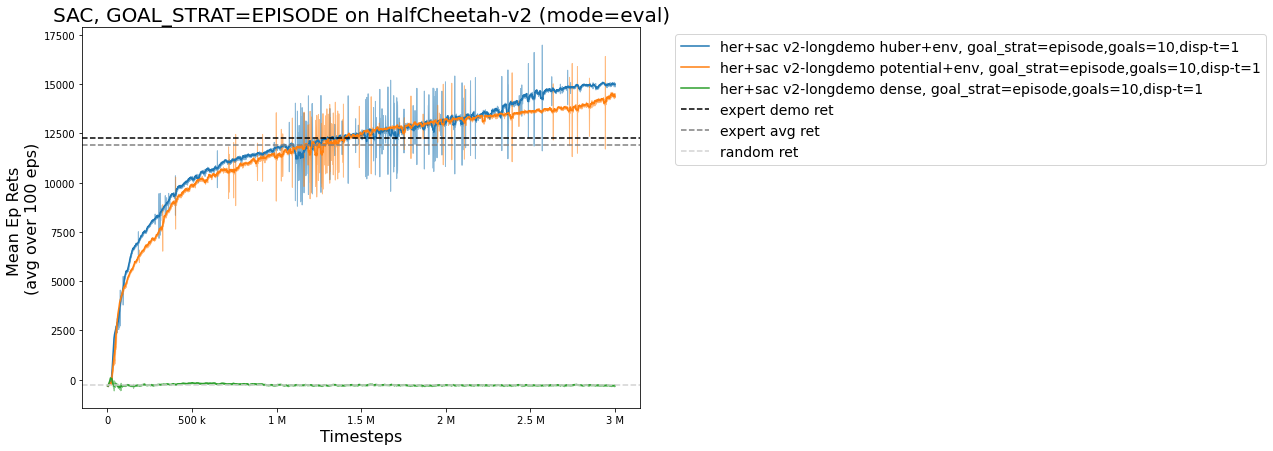

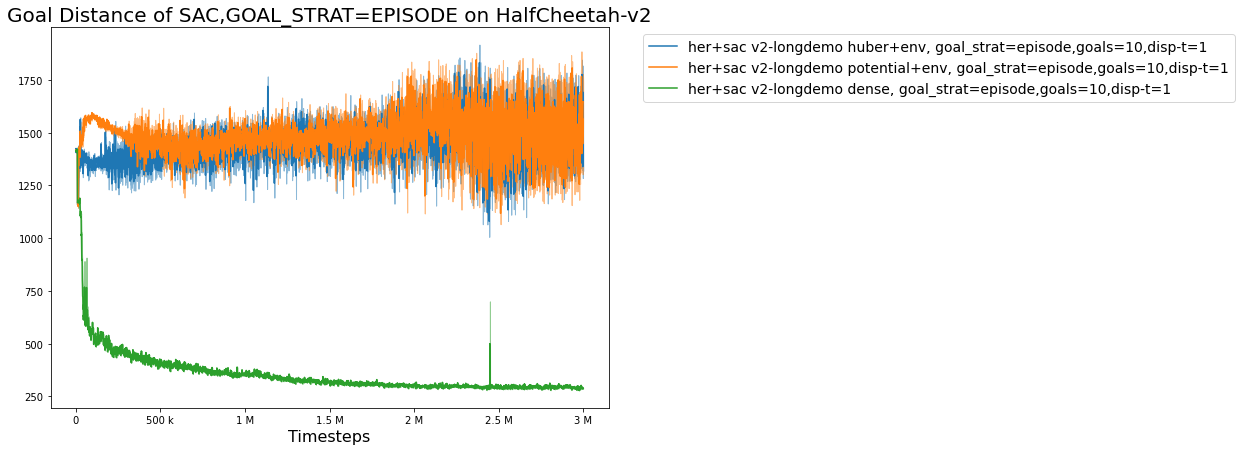

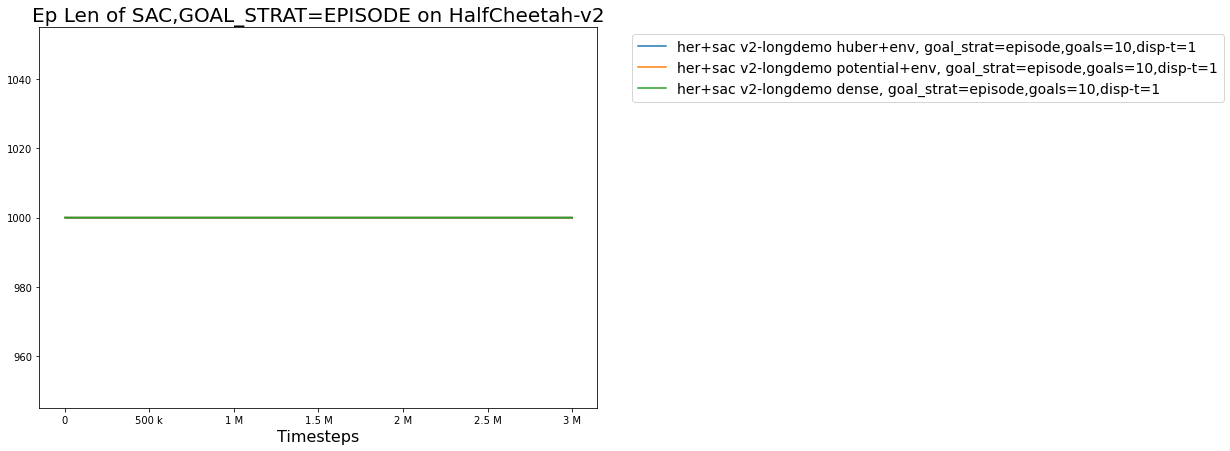

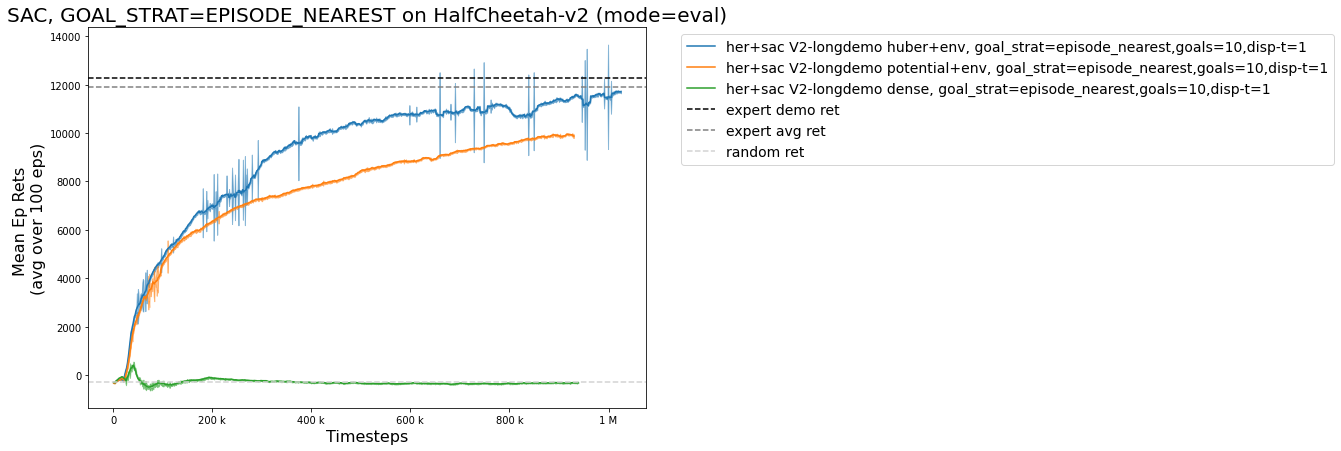

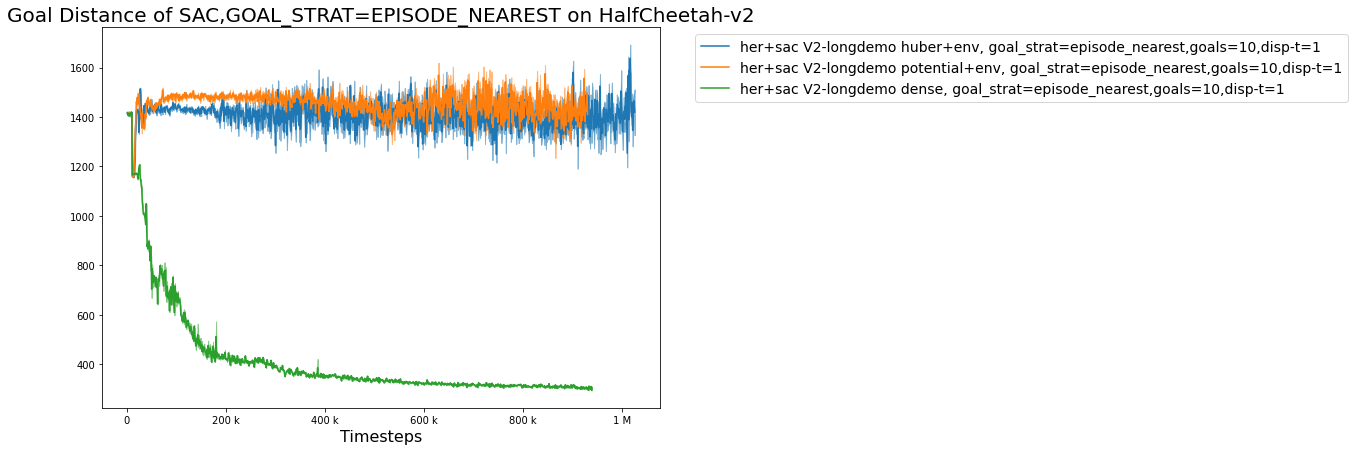

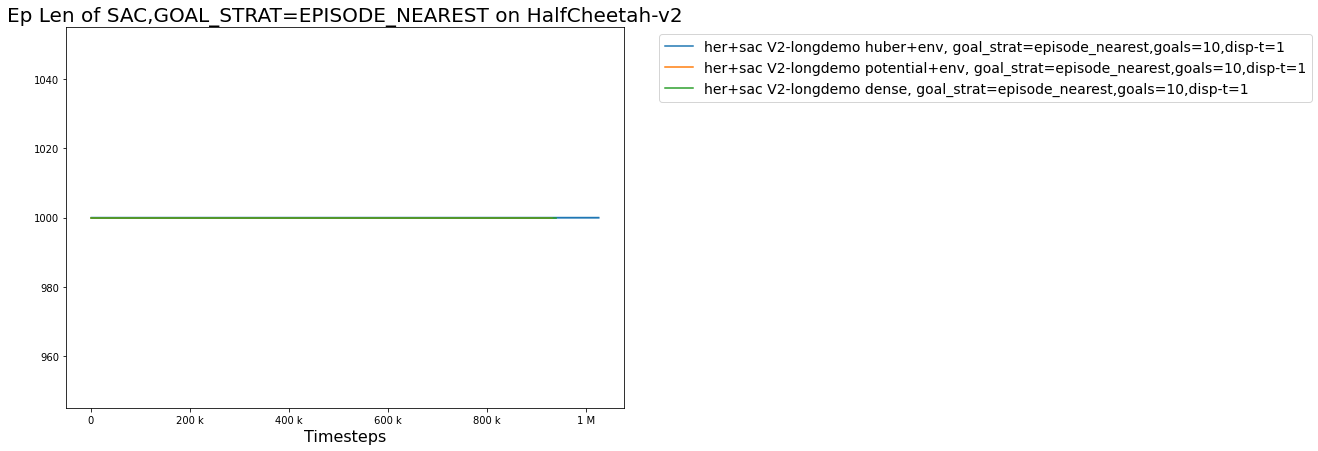

In [41]:
env_id = "HalfCheetah-v2"
run_id = 1
for raw in [True]:
    obs_type = "raw"
    for time_feat in [True]:
        for goal_strat in [
#                            "next_state_and_ep",  
                           "episode",
#                            "next_state" #"future"
                           "episode_nearest"
                          ]:
            if goal_strat == "episode_nearest":
                eval_data_dict = {
                      f"her+{algo} V2-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} V2-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} V2-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),                    
                }
            else: 
                eval_data_dict = {
#                       f"her+{algo} V2 huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} V2 potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} V2 dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

                      f"her+{algo} v2-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} v2-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} v2-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            if goal_strat == "next_state_and_ep": 
                eval_data_dict = {**eval_data_dict,
                              f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat={goal_strat}_n-goal=0_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                               f"her+{algo} huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                               f"her+{algo} potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                               f"her+{algo} dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()}, GOAL_STRAT={goal_strat}", env=env_id, eval_mode=True)
            plot_goal_dist(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)
            plot_ep_lens(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)

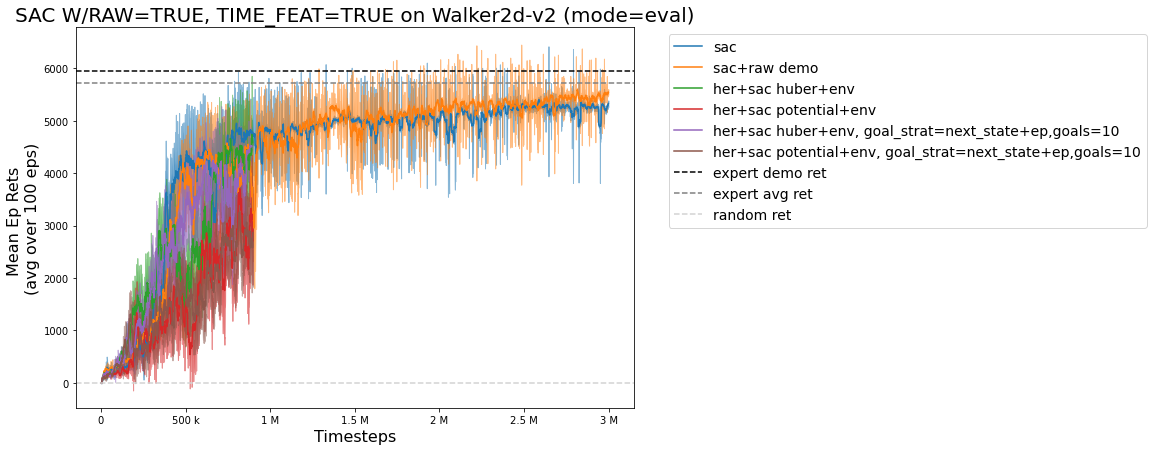

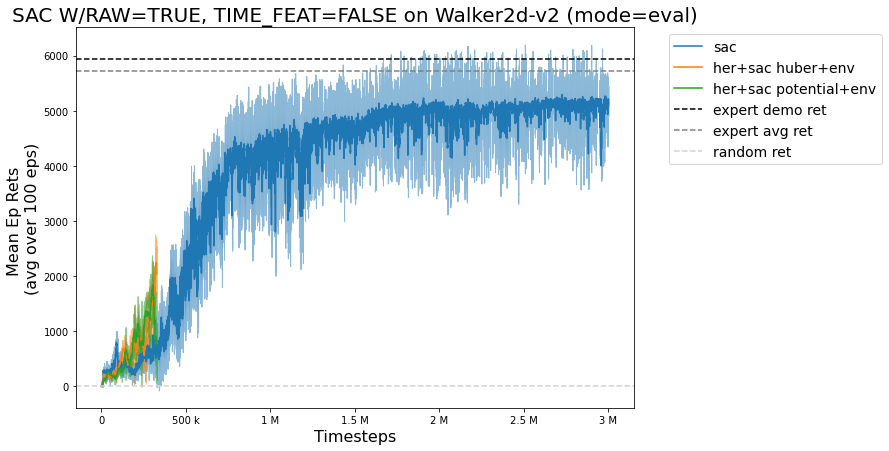

In [37]:
env_id = "Walker2d-v2"
run_id = 1
for raw in [
            True, 
#             False
            ]:
    if raw: 
        obs_type = "raw"
    else:
        obs_type = "full"
    
    for time_feat in [True, 
                      False
                     ]:
        if time_feat: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/time_feature_rl/log/{algo}_{env_id}_{run_id}/"),        
                          f"{algo}+{obs_type} demo": read_eval_data(f"{RESULTS_DIR}/{obs_type}_demo_time_feat_rl_displace-t=0_demo=sac/log/{algo}_{env_id}_{run_id}/"),                                     
                             }
        else: 
            eval_data_dict = {
                          f"{algo}": read_eval_data(f"{RESULTS_DIR}/baseline_rl/log/{algo}_{env_id}_1/"),
                             }

        eval_data_dict = {**eval_data_dict,
#                   f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat=episode_n-goal=0_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                  f"her+{algo} huber+env": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
                  f"her+{algo} potential+env": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                   f"her+{algo} dense": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=episode_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                         }

        if raw and time_feat: 
            eval_data_dict = {**eval_data_dict, 
#                           f"her+{algo} huber+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=1_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} huber+env, goal_strat=next_state,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

#                           f"her+{algo} huber+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
#                           f"her+{algo} potential+env, goal_strat=next_state,goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state, goals=5,1e-4": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_n-goal=5_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),

                          f"her+{algo} huber+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),        
                          f"her+{algo} potential+env, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
#                           f"her+{algo} dense, goal_strat=next_state+ep,goals=10": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat=next_state_and_ep_n-goal=10_time-feat={time_feat}/log/{algo}_{env_id}_{run_id}/"),
                             }

        plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()} w/raw={raw}, time_feat={time_feat}", env=env_id, eval_mode=True)


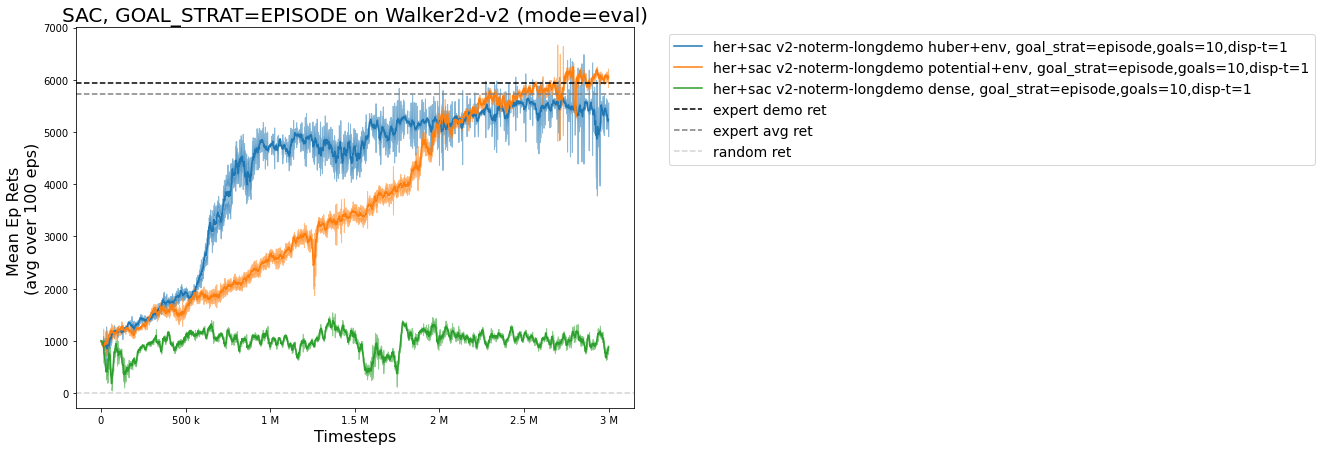

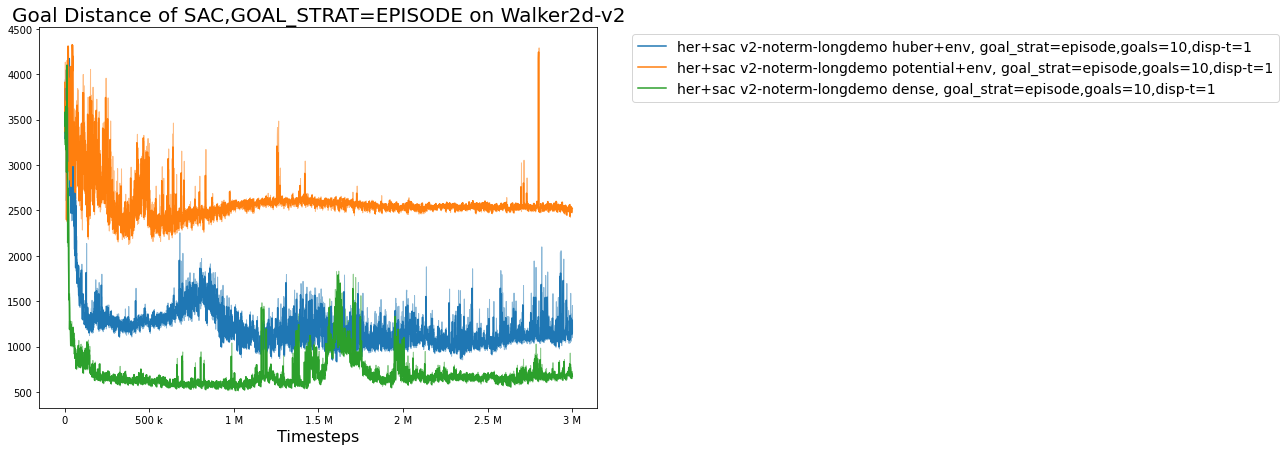

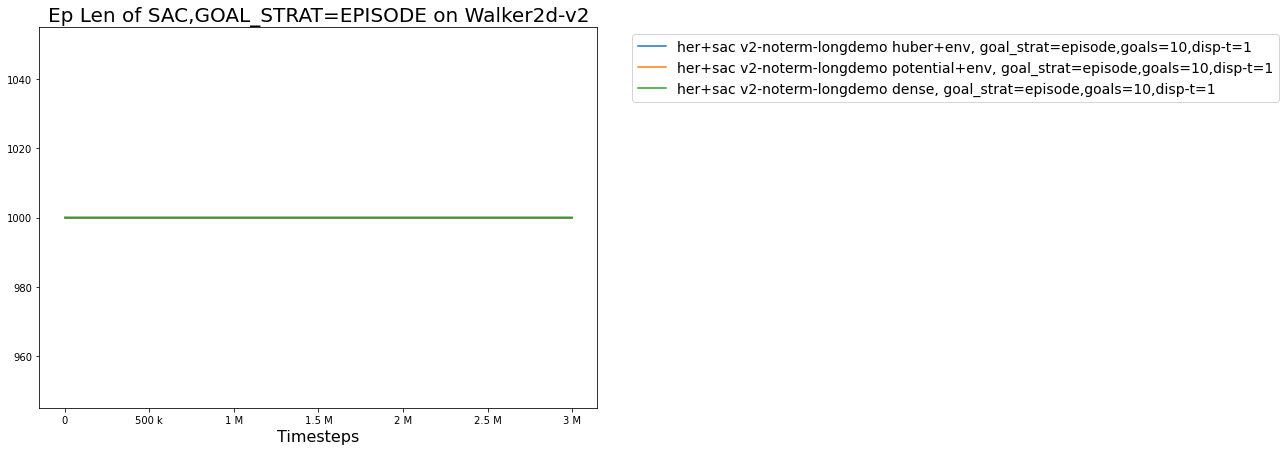

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/ridm_results//her_demo-noterm-longdemo_rew=huber+env_raw=True_goal-strat=future_n-goal=10_time-feat=True_displace-t=1/log/sac_Walker2d-v2_1/evaluations.npz'

In [50]:
env_id = "Walker2d-v2"
run_id = 1
for raw in [True, False]:
    obs_type = "raw"
    for time_feat in [True]:
        for goal_strat in [
#                            "next_state_and_ep",  
                           "episode",
#                            "next_state", 
                            "future",
                           "episode_nearest"
                          ]:
            if goal_strat == "episode_nearest" or goal_strat == "future":
                eval_data_dict = {
                      f"her+{algo} V2-noterm-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} V2-noterm-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} V2-noterm-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),                    
                }
            else: 
                eval_data_dict = {
#                       f"her+{algo} v2-noterm huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} v2-noterm potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} v2-noterm dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-noterm_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

                      f"her+{algo} v2-noterm-longdemo huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
                      f"her+{algo} v2-noterm-longdemo potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                      f"her+{algo} v2-noterm-longdemo dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-longdemo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),

#                       f"her+{algo} V2 huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} V2 potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} V2 dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo-v2_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            if goal_strat == "next_state_and_ep": 
                eval_data_dict = {**eval_data_dict,
                      f"her+{algo} equiv to sac+demo": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=env_raw={raw}_goal-strat={goal_strat}_n-goal=0_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} huber+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=huber+env_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),        
#                       f"her+{algo} potential+env, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=potential_dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
#                       f"her+{algo} dense, goal_strat={goal_strat},goals=10,disp-t=1": read_eval_data(f"{RESULTS_DIR}/her_demo_rew=dense_raw={raw}_goal-strat={goal_strat}_n-goal=10_time-feat={time_feat}_displace-t=1/log/{algo}_{env_id}_{run_id}/"),
                }
            plot_algo_with_demo(eval_data_dict, algo=f"{algo.upper()}, GOAL_STRAT={goal_strat}", env=env_id, eval_mode=True)
            plot_goal_dist(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)
            plot_ep_lens(eval_data_dict, algo=f"{algo.upper()},GOAL_STRAT={goal_strat}", env=env_id)